<a href="https://colab.research.google.com/github/altaga/Pytorch-Driving-Guardian/blob/main/Hardware%20Code/Jetson%20Code/Drowsiness/Drowsiness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Drowsiness Driving Monitor:

Testing Module

In this section we are going to download all the necessary files directly from the repository to be able to carry out the model tests.

In [ ]:
# Haarcascades files.
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
# Blink Pytorch Model:
!wget https://github.com/altaga/Pytorch-Driving-Guardian/blob/main/Hardware%20Code/Jetson%20Code/Drowsiness/model/BlinkModel.t7?raw=true -O BlinkModel.t7
# Model and BackPropagation Utility.
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/Drowsiness/utils/model.py
!wget https://raw.githubusercontent.com/altaga/Pytorch-Driving-Guardian/main/Hardware%20Code/Jetson%20Code/Drowsiness/utils/grad_cam.py
# Testing Images
!wget https://i.ibb.co/YX91y16/c1.png
!wget https://i.ibb.co/7n8MZSL/c2.png
!wget https://i.ibb.co/tcPhrRC/c3.png

Importing Libraries


In [ ]:
import cv2
import matplotlib.pyplot as plt
from IPython import display
import model # Module with the model.
import torch
import os
from torchvision import transforms
from PIL import Image
from grad_cam import BackPropagation

Pytorch Convolutional Neural Network Architecture.

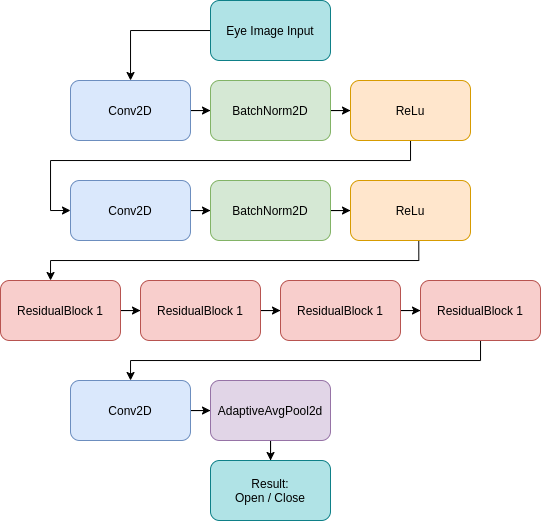

Layers:

- Input Layer: This layer has an input of (24, 24, 1), receiving the data from a 24px high and 24px long grayscale image.
- Conv2D: Convolutional layer for the generation of filters of the input images.
- BatchNorm2D: It helps the convolutional layer to normalize the values after that layer and it helps the network to accelerate its convergence in training.
  - https://arxiv.org/abs/1502.03167
- ReLu: with this layer we eliminate negative activations after each normalization.
- ResidualBlock: This type of block improves the performance of the network by making each one learn even more about the data we are looking to analyze, avoiding performance degradation by adding even more blocks.
  - https://towardsdatascience.com/residual-network-implementing-resnet-a7da63c7b278

Curious fact: The use of Residual Blocks has the function of avoiding the loss of a CNN while the network grows, a problem similar to the RNN networks for NLP, which has the Neural Networks Transformer as a solution.

In [ ]:
import torch.nn as nn

class SeparableConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, dilation, groups=in_channels,
                                   bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, 1, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x


class ResidualBlock(nn.Module):

    def __init__(self, in_channeld, out_channels):
        super(ResidualBlock, self).__init__()

        self.residual_conv = nn.Conv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=1, stride=2,
                                       bias=False)
        self.residual_bn = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)

        self.sepConv1 = SeparableConv2d(in_channels=in_channeld, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.relu = nn.ReLU()

        self.sepConv2 = SeparableConv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, bias=False,
                                        padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels, momentum=0.99, eps=1e-3)
        self.maxp = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        res = self.residual_conv(x)
        res = self.residual_bn(res)
        x = self.sepConv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.sepConv2(x)
        x = self.bn2(x)
        x = self.maxp(x)
        return res + x


class Model(nn.Module):

    def __init__(self, num_classes):
        super(Model, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(8, affine=True, momentum=0.99, eps=1e-3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(8, momentum=0.99, eps=1e-3)
        self.relu2 = nn.ReLU()

        self.module1 = ResidualBlock(in_channeld=8, out_channels=16)
        self.module2 = ResidualBlock(in_channeld=16, out_channels=32)
        self.module3 = ResidualBlock(in_channeld=32, out_channels=64)
        self.module4 = ResidualBlock(in_channeld=64, out_channels=128)

        self.last_conv = nn.Conv2d(in_channels=128, out_channels=num_classes, kernel_size=3, padding=1)
        self.avgp = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, input):
        x = input
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.module1(x)
        x = self.module2(x)
        x = self.module3(x)
        x = self.module4(x)
        x = self.last_conv(x)
        x = self.avgp(x)
        x = x.view((x.shape[0], -1))
        return x

Setup Haarcascade Models and Blink Pytorch Model

In [ ]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml') 
MyModel="BlinkModel.t7"

Setup CNN Input Shape, CNN classes and Global Variables.

In [ ]:
shape = (24,24)
classes = [
    'Close',
    'Open',
]

eyess=[]
cface=0
"""
Depending on the quality of your camera, this number can vary 
between 10 and 40, since this is the "sensitivity" to detect the eyes.
"""
sensi=20

Configure all processes in smaller functions to carry out more structured programming.

In [ ]:
# This function is for the purpose of cropping the eyes out of the image and storing it for further processing in the neural network.
def preprocess(image_path):
    global cface
    global sensi
    transform_test = transforms.Compose([
        transforms.ToTensor()
    ])
    image = cv2.imread(image_path['path'])    
    faces = face_cascade.detectMultiScale(
        image,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(1, 1),
        flags=cv2.CASCADE_SCALE_IMAGE
    )
    if len(faces) == 0:
        ...
    else:
        cface=1
        (x, y, w, h) = faces[0]
        face = image[y:y + h, x:x + w]
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,255,0),2)
        roi_color = image[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(face,1.3, sensi) 
        i=0
        for (ex,ey,ew,eh) in eyes:
            (x, y, w, h) = eyes[i]
            cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
            eye = face[y:y + h, x:x + w]
            eye = cv2.resize(eye, shape)
            # Saving detections into array
            eyess.append([transform_test(Image.fromarray(eye).convert('L')), eye, cv2.resize(face, (48,48))])
            i=i+1
    cv2.imwrite('display.jpg',image) 
    
# This function is for the purpose of cropping the eyes out of the image and storing it for further processing in the neural network.
def eye_status(image, name, net):
    img = torch.stack([image[name]])
    bp = BackPropagation(model=net)
    probs, ids = bp.forward(img)
    actual_status = ids[:, 0]
    prob = probs.data[:, 0]
    if actual_status == 0:
        prob = probs.data[:,1]
    #print(name,classes[actual_status.data], probs.data[:,0] * 100)
    return classes[actual_status.data]

# Main function for processing the images to obtain an image to display on the laptop.
def drow(images, model_name):
    global eyess
    global cface
    # Main function for processing the images to obtain an image to display on the laptop.
    net = model.Model(num_classes=len(classes))
    checkpoint = torch.load(MyModel, map_location=torch.device('cpu'))
    net.load_state_dict(checkpoint['net'])
    net.eval()
    flag =1
    status=""
    for i, image in enumerate(images):
        if(flag):
            # Proprocessing the input image.
            preprocess(image)
            flag=0
        if cface==0:
            # if the preprocessing does not see any faces, we indicate that we have not seen a face.
            image = cv2.imread("display.jpg")
            image = cv2.putText(image, 'No face Detected', (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 7, (255, 0, 0), 10, cv2.LINE_AA)
            cv2.imwrite('display.jpg',image)
        elif(len(eyess)!=0):
            # If we have seen eyes in the image, we run them through the neural network to determine whether the eyes are distracted or not.
            eye, eye_raw , face = eyess[i]
            image['eye'] = eye
            image['raw'] = eye_raw
            image['face'] = face
            for index, image in enumerate(images):
                status = eye_status(image, 'eye', net)
                if(status =="Close"):
                    image = cv2.imread("display.jpg")
                    image = cv2.putText(image, 'Distracted', (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 7, (255, 0, 0), 10, cv2.LINE_AA)
                    cv2.imwrite('display.jpg',image)       
        else:
            # If we do not detect eyes in the image, it is possible that the eyes are closed and therefore Drowsy.
            image = cv2.imread("display.jpg")
            image = cv2.putText(image, 'Drowsy', (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 7, (255, 0, 0), 10, cv2.LINE_AA)
            cv2.imwrite('display.jpg',image)

# General function to call all processes, this function has the only function of having a more aesthetic code at the end.
def func(imag,modl):
    drow(images=[{'path': imag, 'eye': (0,0,0,0)}],model_name=modl)

In this section we will show the 3 examples we did to show that the model works.

In [ ]:
# Normal image of a person looking straight ahead.
eyess=[]
func("c1.png",MyModel)
image = cv2.imread("display.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
# If the person is falling asleep, the Drowsy status is displayed
eyess=[]
func("c2.png",MyModel)
image = cv2.imread("display.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
# If the person is not asleep, but is distracted, the Distracted state is displayed.
eyess=[]
func("c3.png",MyModel)
image = cv2.imread("display.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)